# Here we want to use methods of Relevance of Negative Links in Graph Partitioning: A Case Study Using Votes From the European Parliament and Identifying hidden coalitions in the US House of Representatives by optimally partitioning signed networks based on generalized balance

Link 1: https://hal.science/hal-01176090/document

Link 2: https://www.nature.com/articles/s41598-021-98139-w

2 main outputs:

- Agreement distribution plots and agreement matrices per party per legislature
- Frustration analysis of partitions from k=2 to k=8


=== Processing EP6 ===
Number of votes taken into account: 1253
Graph built: 911 nodes, 403405 edges

--- Results ---
Positive-only modularity:          0.029
Complementary-negative modularity: 0.007
Signed imbalance (I):              0.459
NMI (positive vs signed):          0.903


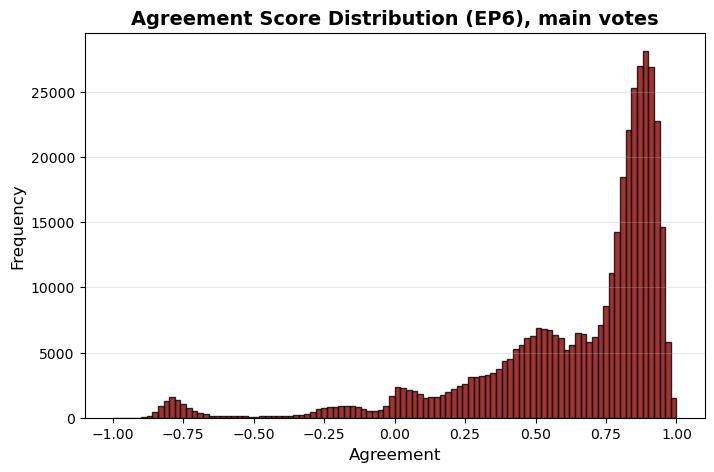

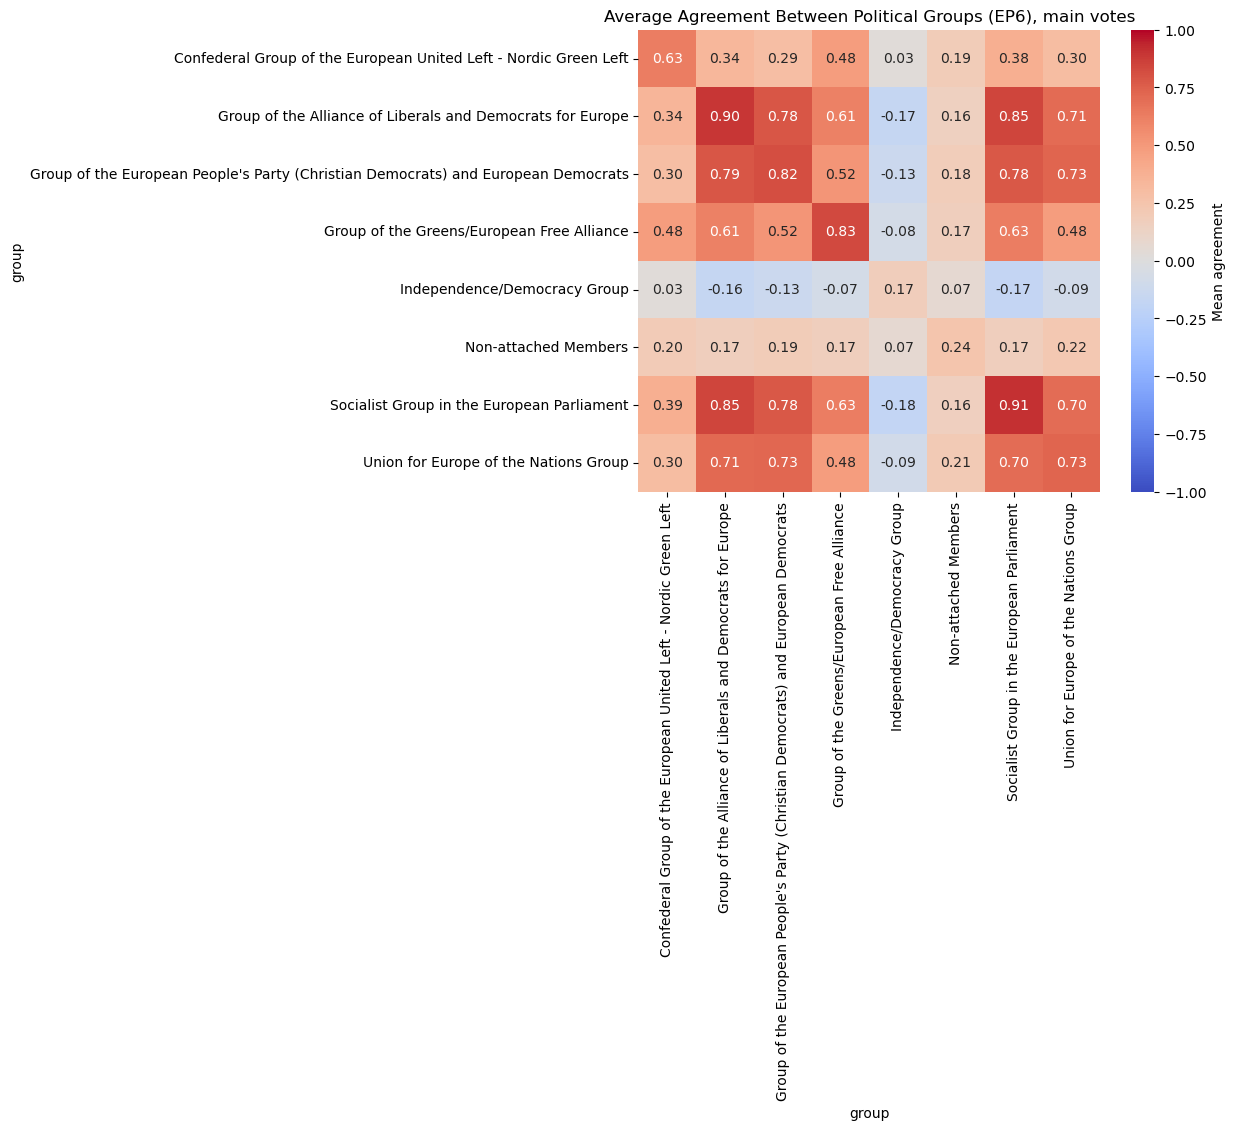


=== Processing EP7 ===
Number of votes taken into account: 1664
Graph built: 844 nodes, 351046 edges

--- Results ---
Positive-only modularity:          0.033
Complementary-negative modularity: 0.008
Signed imbalance (I):              0.328
NMI (positive vs signed):          0.389


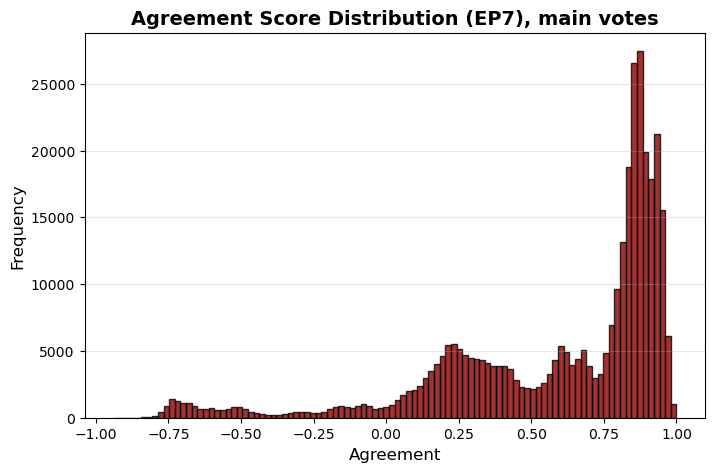

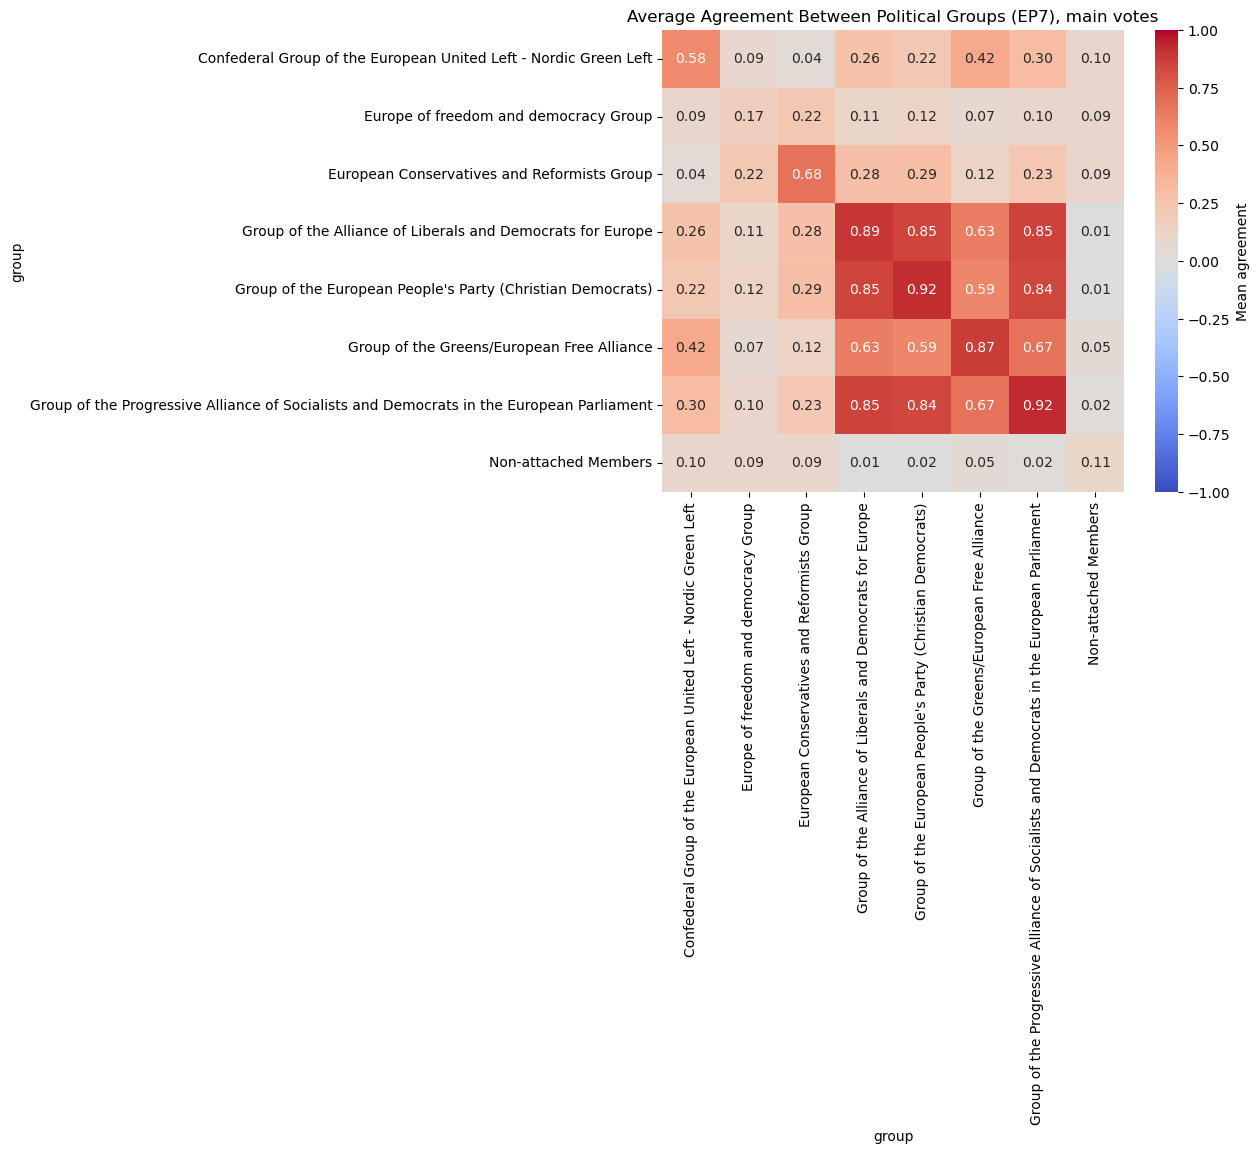


=== Processing EP8 ===
Number of votes taken into account: 2072
Graph built: 833 nodes, 342645 edges

--- Results ---
Positive-only modularity:          0.063
Complementary-negative modularity: 0.046
Signed imbalance (I):              0.270
NMI (positive vs signed):          0.814


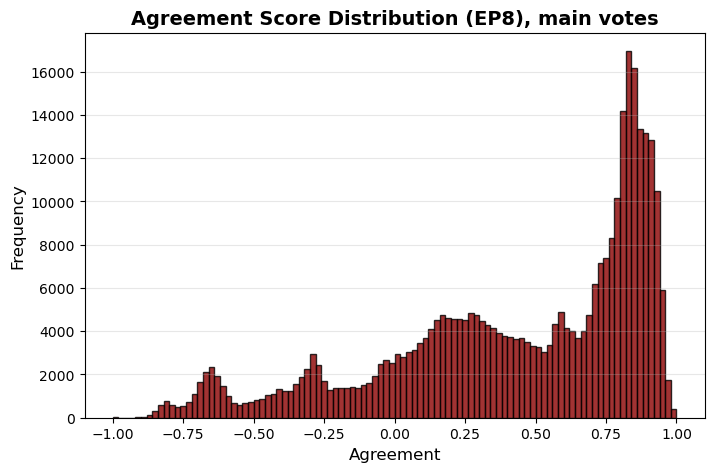

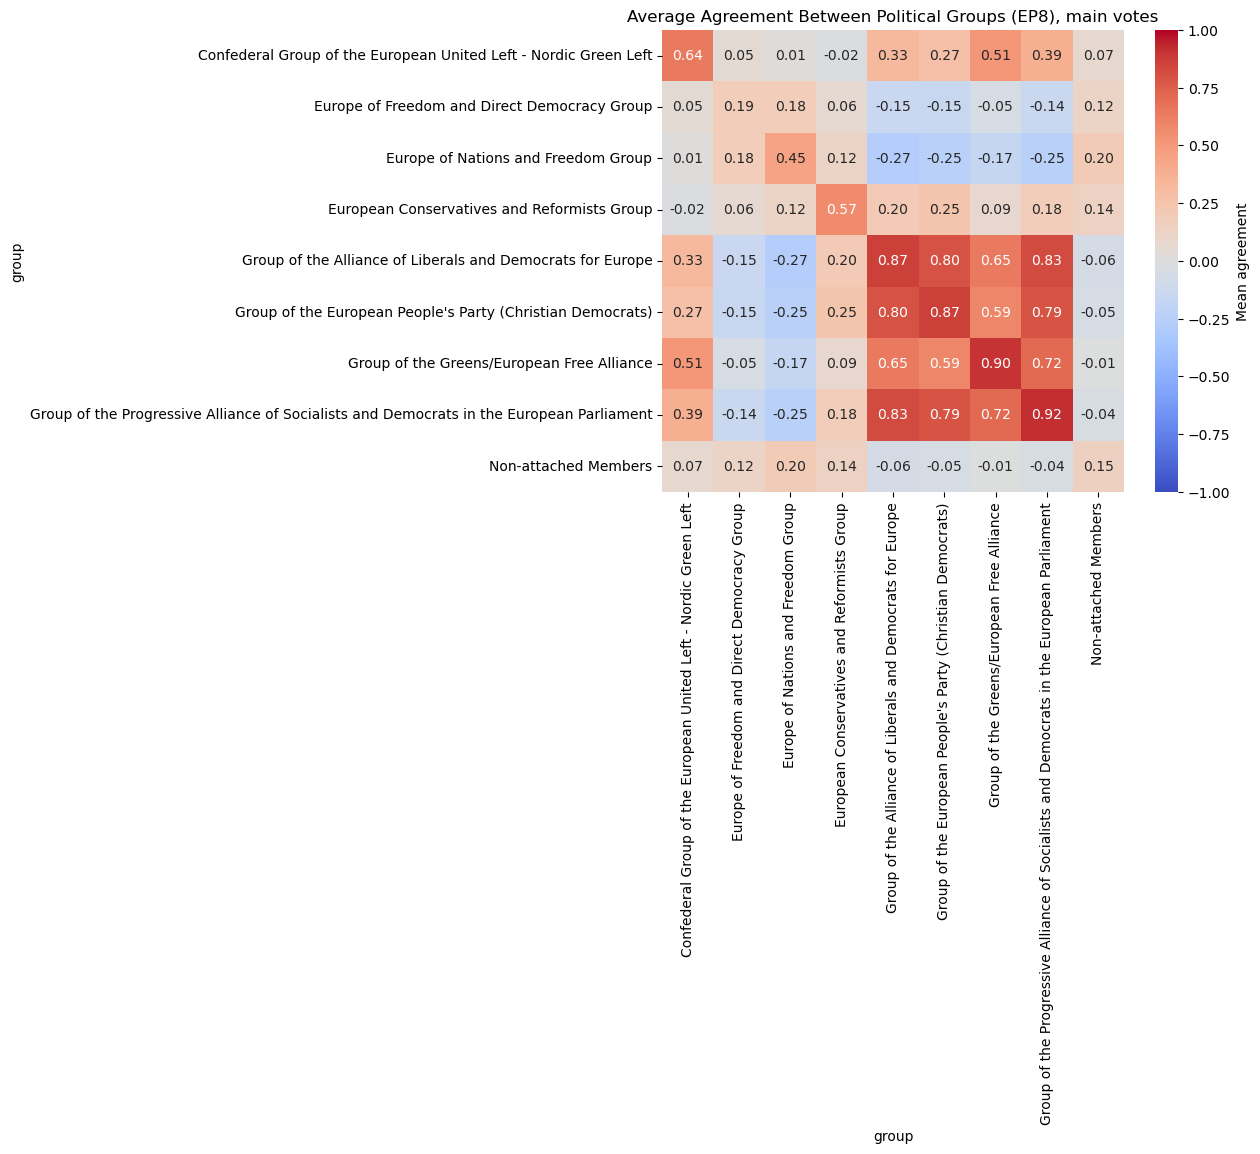


=== Processing EP9 ===
Number of votes taken into account: 1805
Graph built: 851 nodes, 349771 edges

--- Results ---
Positive-only modularity:          0.063
Complementary-negative modularity: 0.042
Signed imbalance (I):              0.292
NMI (positive vs signed):          0.691


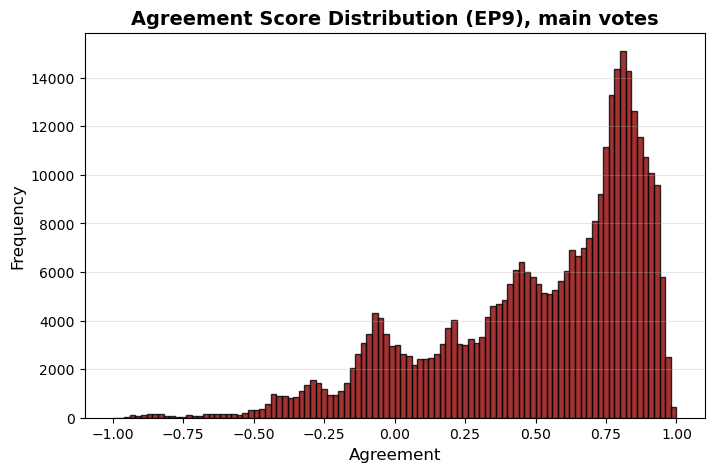

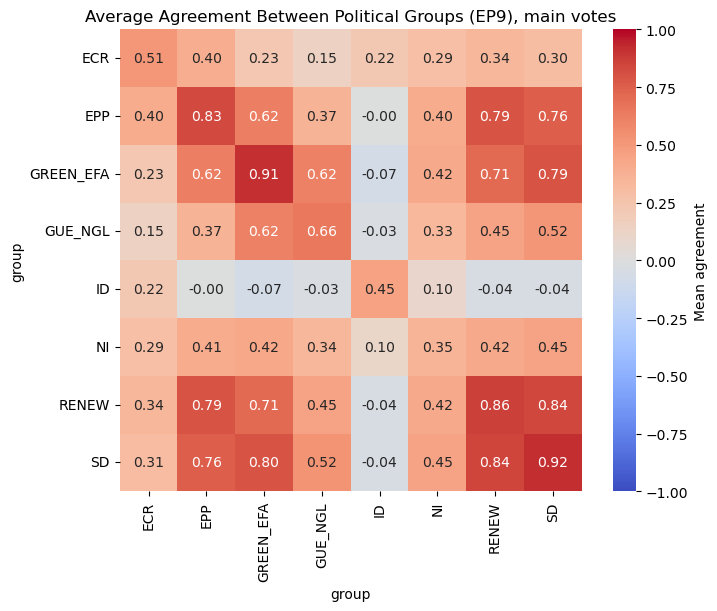


=== Processing EP10 ===
Number of votes taken into account: 291
Graph built: 725 nodes, 262347 edges

--- Results ---
Positive-only modularity:          0.111
Complementary-negative modularity: 0.089
Signed imbalance (I):              0.229
NMI (positive vs signed):          0.941


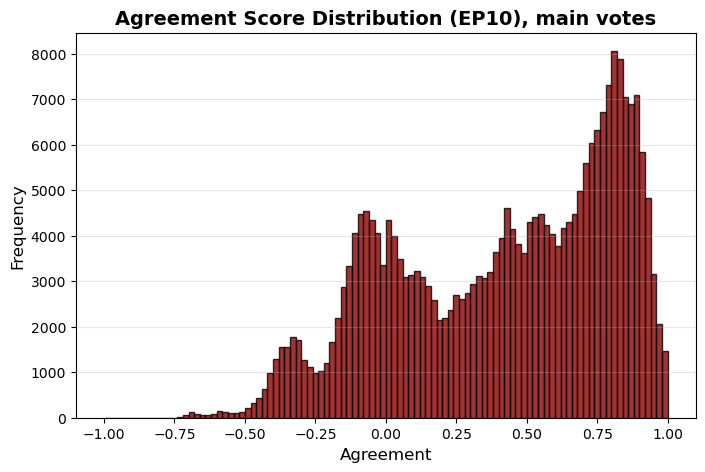

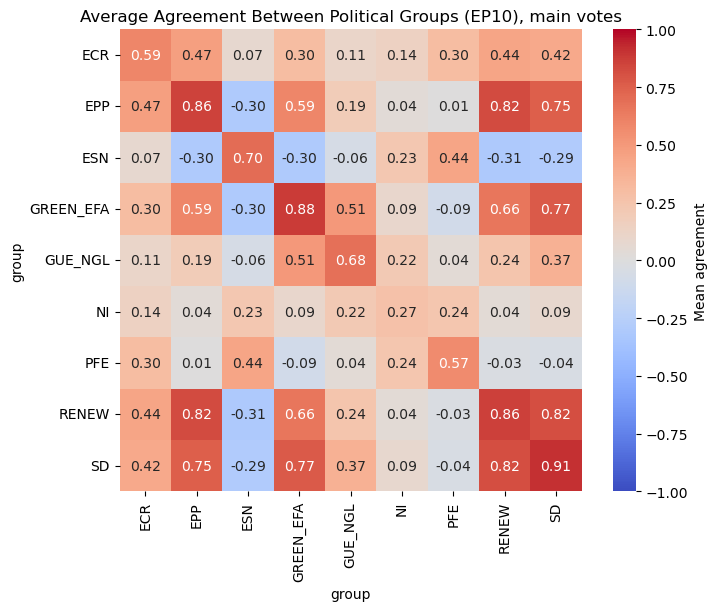


=== Evolution of metrics across legislatures ===


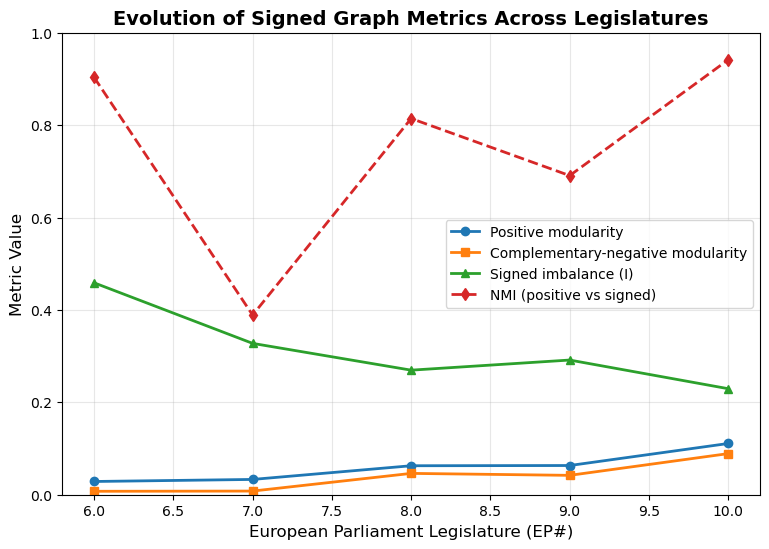

In [4]:
# --- Signed Graph Partitioning: Efficient Version ---
# Inspired by Mendonça et al. (2016)
# Fully vectorized pairwise agreement computation (no nested loops)

import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# STEP 1. Build signed weighted network (vectorized)
# -------------------------------------------------------------------

def build_signed_graph_fast(vote_df):
    """
    Build a signed, weighted graph from a DataFrame of votes (vectorized).
    Rows = MEPs, columns = resolutions, values = {'FOR','AGAINST','ABSTENTION','DID_NOT_VOTE'}.
    Returns:
        G: signed NetworkX graph
        W: agreement matrix (numpy array)
        meps: list of MEP names
    """
    mapping = {'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': np.nan}
    votes_num = vote_df.replace(mapping)
    V = votes_num.to_numpy(dtype=float)
    n = V.shape[0]

    # Mask for valid entries
    mask = (~np.isnan(V)).astype(float)
    V_masked = np.nan_to_num(V, nan=0.0)

    # Pairwise valid counts and dot products
    valid_counts = mask @ mask.T
    dot_products = (V_masked * mask) @ (V_masked * mask).T # 1*1 FORFOR, -1*-1 AGAINSTAGAINST, -1*1 FORAGAINST, 0 ABSTAIN***
    # Average agreement in [-1, 1]
    agreement = np.divide(dot_products, valid_counts, out=np.zeros_like(dot_products), where=valid_counts > 0)

    min_shared_votes = 5
    agreement[valid_counts < min_shared_votes] = np.nan

    # Build graph
    G = nx.Graph()
    names = vote_df.index.tolist()
    for i in range(n):
        for j in range(i + 1, n):
            w = agreement[i, j]
            if valid_counts[i, j] == 0 or np.isnan(w):
                continue
            G.add_edge(names[i], names[j], weight=abs(w), sign='+' if w >= 0 else '-')

    return G, agreement, names


# -------------------------------------------------------------------
# STEP 2. Subgraphs
# -------------------------------------------------------------------

def positive_subgraph(G):
    """Return subgraph with only positive edges."""
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v, d in G.edges(data=True):
        if d['sign'] == '+':
            H.add_edge(u, v, weight=d['weight'])
    return H


def complementary_negative_subgraph(G):
    """Return complement of the negative subgraph (as in Mendonça et al.)."""
    nodes = list(G.nodes)
    neg_edges = {(min(u, v), max(u, v)) for u, v, d in G.edges(data=True) if d['sign'] == '-'}
    H = nx.Graph()
    H.add_nodes_from(nodes)
    for i, u in enumerate(nodes):
        for v in nodes[i + 1:]:
            if (u, v) not in neg_edges:
                H.add_edge(u, v, weight=1.0)
    return H


# -------------------------------------------------------------------
# STEP 3. Metrics & Algorithms
# -------------------------------------------------------------------

def louvain_partition(G):
    if len(G) == 0:
        return {}, 0
    partition = community_louvain.best_partition(G, weight='weight')
    modularity = community_louvain.modularity(partition, G, weight='weight')
    return partition, modularity


def compute_imbalance(G, partition):
    """Imbalance I(P): negative edges within clusters + positive edges between clusters."""
    if len(G.edges) == 0:
        return 0
    imb = sum(
        d['weight']
        for u, v, d in G.edges(data=True)
        if (d['sign'] == '-' and partition[u] == partition[v]) or
           (d['sign'] == '+' and partition[u] != partition[v])
    )
    return imb / len(G.edges)


# -------------------------------------------------------------------
# STEP 4. Full analysis
# -------------------------------------------------------------------

def analyze_signed_graph(vote_df):
    G, W, meps = build_signed_graph_fast(vote_df)
    print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    G_pos = positive_subgraph(G)
    G_cneg = complementary_negative_subgraph(G)

    part_pos, mod_pos = louvain_partition(G_pos)
    part_cneg, mod_cneg = louvain_partition(G_cneg)
    part_signed, mod_signed = louvain_partition(nx.Graph(G))  # ignoring sign
    imb_signed = compute_imbalance(G, part_signed)

    nmi = normalized_mutual_info_score(
        [part_pos.get(n, -1) for n in G.nodes],
        [part_signed.get(n, -1) for n in G.nodes]
    )

    print("\n--- Results ---")
    print(f"Positive-only modularity:          {mod_pos:.3f}")
    print(f"Complementary-negative modularity: {mod_cneg:.3f}")
    print(f"Signed imbalance (I):              {imb_signed:.3f}")
    print(f"NMI (positive vs signed):          {nmi:.3f}")

    return G, W, meps, dict(mod_pos=mod_pos, mod_cneg=mod_cneg, imb_signed=imb_signed, nmi=nmi)


# -------------------------------------------------------------------
# STEP 5. Plots
# -------------------------------------------------------------------

def plot_agreement_matrix(W, meps, vote_df, group_col='member.group.short_label', EP_number=100, main=True):
    """Plot average pairwise agreement between political groups."""
    if group_col not in vote_df.columns:
        print(f"Column '{group_col}' not found — skipping group-level plot.")
        return None
    if main:
        title = f"Average Agreement Between Political Groups (EP{EP_number}), main votes"
    else:
        title = f"Average Agreement Between Political Groups (EP{EP_number}), all votes"

    groups = vote_df[group_col]
    df = pd.DataFrame(W, index=meps, columns=meps)
    df['group'] = groups.values[:len(df)]  # align safely
    df = df.dropna(subset=['group'])

    # Compute mean agreement between groups
    agg = (df.drop(columns='group')
             .groupby(df['group'])
             .mean()
             .T
             .groupby(df['group'])
             .mean())

    plt.figure(figsize=(8, 6))
    sns.heatmap(agg, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                annot=True, fmt=".2f", square=True, cbar_kws={'label': 'Mean agreement'})
    plt.title(title)
    #plt.tight_layout()
    plt.show()
    return agg


def plot_agreement_distribution(W, EP_number=100, main=True):
    """Plot histogram of pairwise agreement scores (like Mendonça et al. Fig. 2)."""
    upper_vals = W[np.triu_indices_from(W, k=1)]
    upper_vals = upper_vals[~np.isnan(upper_vals)]
    if main:
        title = f"Agreement Score Distribution (EP{EP_number}), main votes"
    else:
        title = f"Agreement Score Distribution (EP{EP_number}), all votes"

    plt.figure(figsize=(8, 5))
    plt.hist(upper_vals, bins=100, color='darkred', edgecolor='black', alpha=0.8)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Agreement", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    #plt.tight_layout()
    plt.show()

def plot_metrics_evolution(results_dict):
    """
    Plot the evolution of modularity, imbalance, and NMI across legislatures.

    Parameters
    ----------
    results_dict : dict
        Keys = EP numbers (e.g. 6, 7, 8, 9, 10)
        Values = dicts with the following keys:
            'mod_pos', 'mod_cneg', 'imb_signed', 'nmi'
    """
    # Convert to Dataframe and sort by legislature number
    df = pd.DataFrame(results_dict).T.sort_index()

    plt.figure(figsize=(9, 6))
    
    # Plot all metrics together
    plt.plot(df.index, df['mod_pos'], 'o-', label='Positive modularity', linewidth=2)
    plt.plot(df.index, df['mod_cneg'], 's-', label='Complementary-negative modularity', linewidth=2)
    plt.plot(df.index, df['imb_signed'], '^-', label='Signed imbalance (I)', linewidth=2)
    plt.plot(df.index, df['nmi'], 'd--', label='NMI (positive vs signed)', linewidth=2)

    # Styling
    plt.title("Evolution of Signed Graph Metrics Across Legislatures", fontsize=14, fontweight='bold')
    plt.xlabel("European Parliament Legislature (EP#)", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.legend(frameon=True)
    #plt.tight_layout()
    plt.show()

    return df


if __name__ == "__main__":
    main = True  # True = only main votes, False = all votes
    all_results = {}

    for EP_number in range(6, 11):
        print(f"\n=== Processing EP{EP_number} ===")
        if main:
            votes = pd.read_csv(f"data/all_votes_main_EP{EP_number}.csv", low_memory=False)
        else:
            votes = pd.read_csv(f"data/all_votes_EP{EP_number}.csv", low_memory=False)

        # Keep only vote columns
        vote_cols = [c for c in votes.columns if c.isdigit()]
        votes_core = votes[vote_cols].copy()

        # Remove rows (MEPs) with >70% missing votes
        valid_rows = votes_core.isna().sum(axis=1) < 0.9 * len(votes_core.columns)
        votes_core = votes_core.loc[valid_rows]
        votes = votes.loc[valid_rows]

        # Reset index for stability
        votes_core.index = np.arange(len(votes_core))

        print(f"Number of votes taken into account: {len(votes_core.columns)}")

        # --- Run full analysis ---
        G, W, meps, results = analyze_signed_graph(votes_core)
        all_results[EP_number] = results  # store results

        # --- Agreement histogram ---
        plot_agreement_distribution(W, EP_number=EP_number, main=main)

        # --- Agreement matrix (if group data available) ---
        if "member.group.short_label" in votes.columns:
            plot_agreement_matrix(
                W, meps, votes,
                group_col="member.group.short_label",
                EP_number=EP_number, main=main
            )

    # --- After processing all legislatures, plot metric evolution ---
    print("\n=== Evolution of metrics across legislatures ===")
    plot_metrics_evolution(all_results)

Graph built: 841 nodes, 350256 edges

--- Results ---
Positive-only modularity:          0.025
Complementary-negative modularity: 0.007
Signed imbalance (I):              0.384
NMI (positive vs signed):          0.801
Graph built: 812 nodes, 327281 edges

--- Results ---
Positive-only modularity:          0.033
Complementary-negative modularity: 0.008
Signed imbalance (I):              0.386
NMI (positive vs signed):          0.849
Graph built: 806 nodes, 322498 edges

--- Results ---
Positive-only modularity:          0.062
Complementary-negative modularity: 0.047
Signed imbalance (I):              0.317
NMI (positive vs signed):          0.677
Graph built: 768 nodes, 291902 edges

--- Results ---
Positive-only modularity:          0.062
Complementary-negative modularity: 0.044
Signed imbalance (I):              0.280
NMI (positive vs signed):          0.886
Graph built: 719 nodes, 258119 edges

--- Results ---
Positive-only modularity:          0.111
Complementary-negative modularity

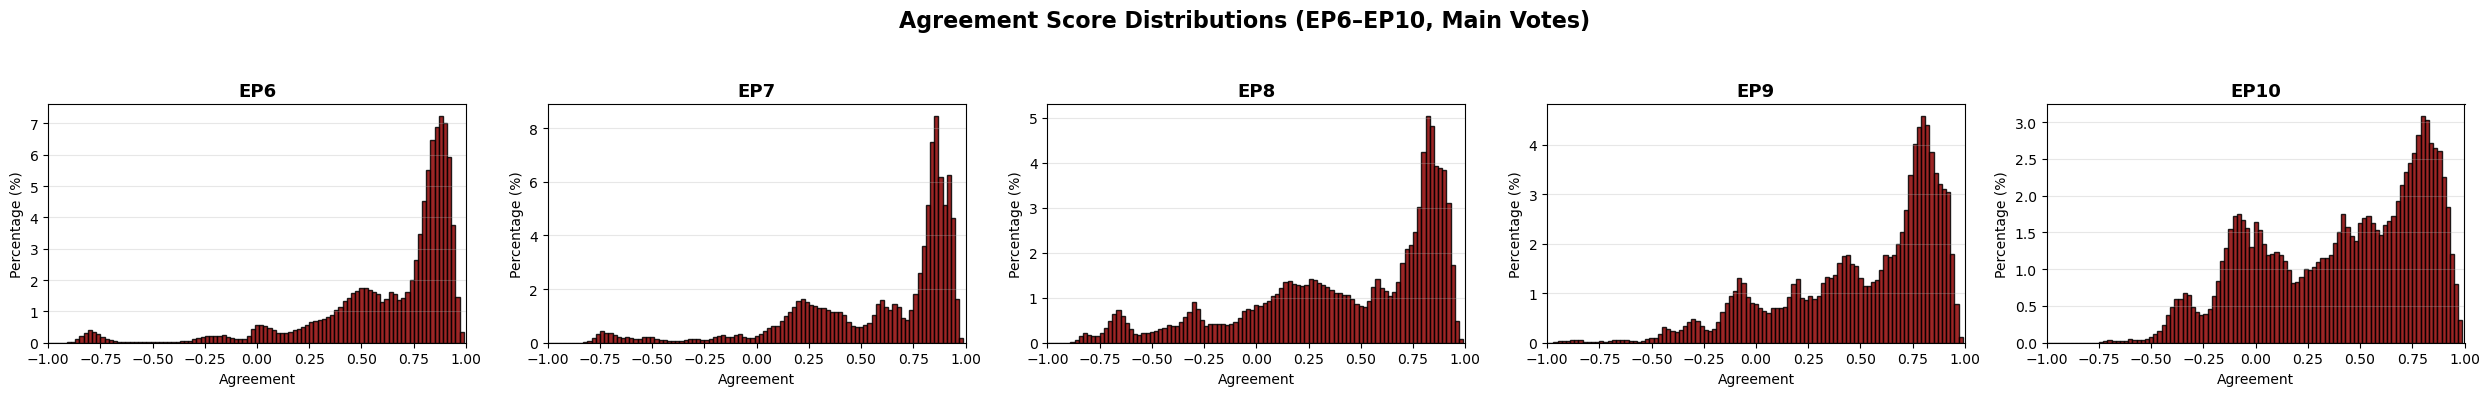

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming analyze_signed_graph() is defined from before and returns W

agreements_all = {}

for EP_number in range(6, 11):
    votes = pd.read_csv(f"data/all_votes_main_EP{EP_number}.csv", low_memory=False)

    # Keep only main vote columns (numeric names)
    vote_cols = [c for c in votes.columns if c.isdigit()]
    votes_core = votes[vote_cols]
    votes_core = votes_core[votes_core.isna().sum(axis=1) < 0.7 * len(votes_core.columns)]
    votes_core.index = np.arange(len(votes_core))

    # Analyze
    G, W, meps, results = analyze_signed_graph(votes_core)

    # Keep upper triangle of agreement matrix
    upper_vals = W[np.triu_indices_from(W, k=1)]
    upper_vals = upper_vals[~np.isnan(upper_vals)]
    agreements_all[EP_number] = upper_vals


# --- Combined horizontal plot, independent y-axis per subplot ---
fig, axes = plt.subplots(1, len(agreements_all), figsize=(5 * len(agreements_all), 4), sharey=False)

for ax, (EP_number, vals) in zip(axes, agreements_all.items()):
    counts, bins = np.histogram(vals, bins=100, range=(-1, 1))
    percentages = 100 * counts / counts.sum()
    
    ax.bar(bins[:-1], percentages, width=bins[1]-bins[0], color='darkred', edgecolor='black', alpha=0.85)
    ax.set_title(f"EP{EP_number}", fontsize=13, fontweight='bold')
    ax.set_xlabel("Agreement")
    ax.set_xlim(-1, 1)
    ax.set_ylabel("Percentage (%)")
    ax.grid(axis='y', alpha=0.3)

plt.suptitle("Agreement Score Distributions (EP6–EP10, Main Votes)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("agreement_distributions_EP6-EP10.png", dpi=300)
plt.show()

In [6]:
# print mean and median of all agreements per EP
for EP_number, vals in agreements_all.items():
    print(f"EP{EP_number}: Mean = {np.mean(vals)}, Median = {np.median(vals)}")


EP6: Mean = 0.6464006213110186, Median = 0.7953125
EP7: Mean = 0.5930977433702229, Median = 0.7911877394636015
EP8: Mean = 0.43486336058452474, Median = 0.5791607981220658
EP9: Mean = 0.5160079184716422, Median = 0.6449298752818555
EP10: Mean = 0.41627194321036126, Median = 0.49137931034482757


# Now i want to perform the US House paper analysis on these datasets


=== Processing EP6 ===
Number of MEPs: 841, Votes: 1253
k=2, frustration=0.0442
k=3, frustration=0.0368
k=4, frustration=0.0344
k=5, frustration=0.0336
k=6, frustration=0.0327
k=7, frustration=0.0327
k=8, frustration=0.0327


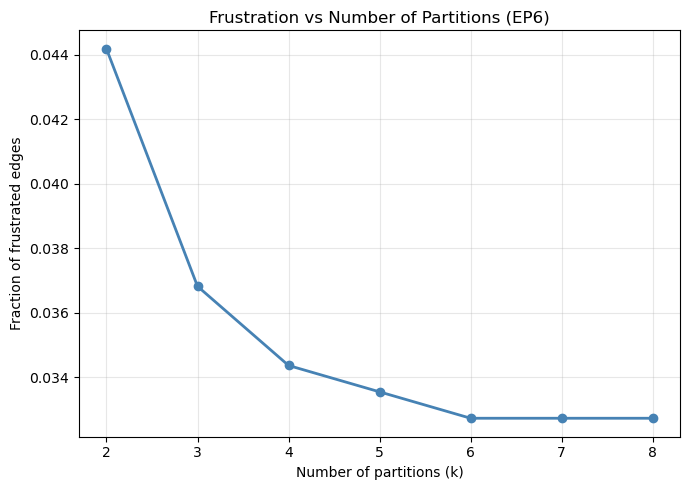


=== Processing EP7 ===
Number of MEPs: 812, Votes: 1664
k=2, frustration=0.1267
k=3, frustration=0.1104
k=4, frustration=0.1047
k=5, frustration=0.1022
k=6, frustration=0.1006
k=7, frustration=0.0998
k=8, frustration=0.0989


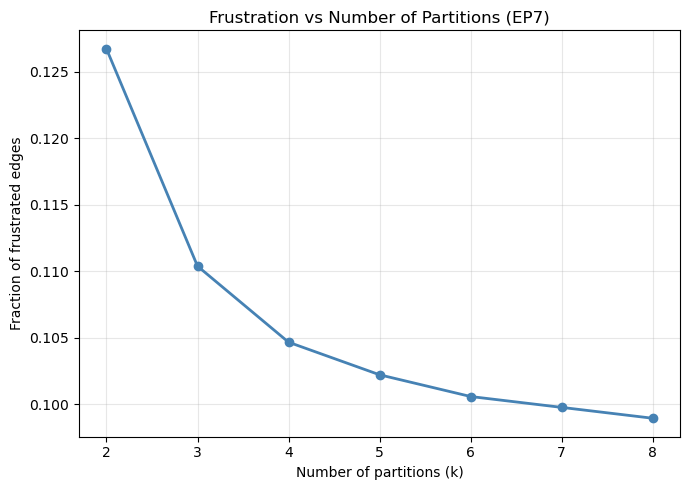


=== Processing EP8 ===
Number of MEPs: 807, Votes: 2072
k=2, frustration=0.0795
k=3, frustration=0.0426
k=4, frustration=0.0295
k=5, frustration=0.0262
k=6, frustration=0.0246
k=7, frustration=0.0205
k=8, frustration=0.0197


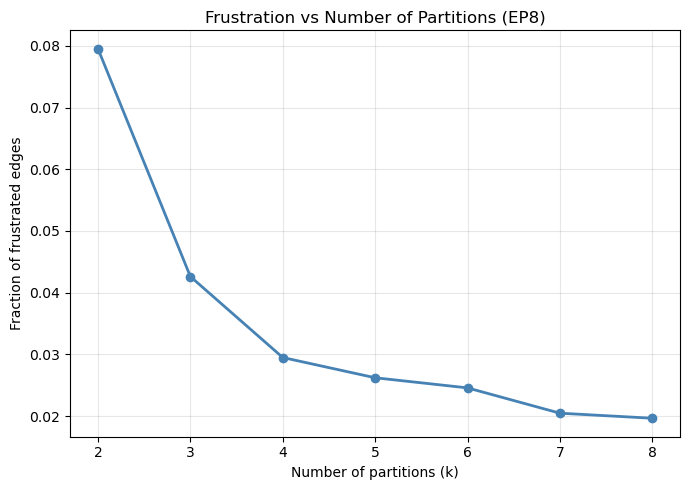


=== Processing EP9 ===
Number of MEPs: 769, Votes: 1805
k=2, frustration=0.0412
k=3, frustration=0.0280
k=4, frustration=0.0239
k=5, frustration=0.0214
k=6, frustration=0.0206
k=7, frustration=0.0198
k=8, frustration=0.0198


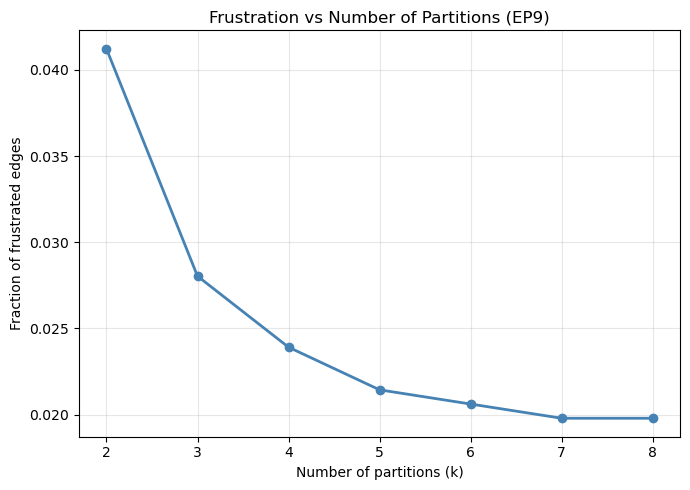


=== Processing EP10 ===
Number of MEPs: 722, Votes: 291
k=2, frustration=0.1200
k=3, frustration=0.0800
k=4, frustration=0.0669
k=5, frustration=0.0612
k=6, frustration=0.0588
k=7, frustration=0.0571
k=8, frustration=0.0563


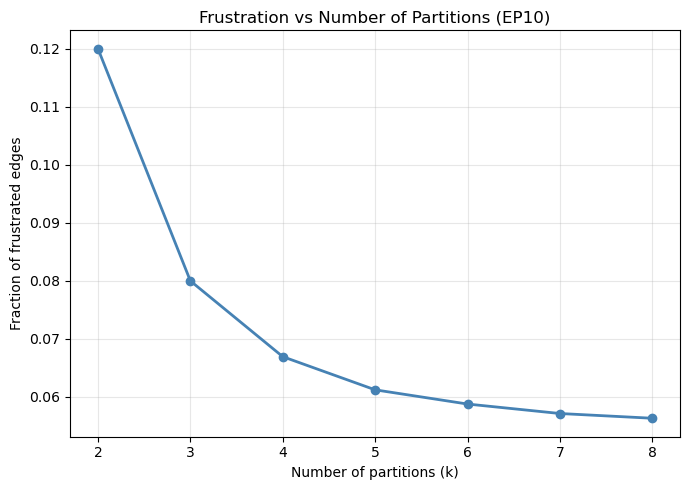

In [61]:
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from sklearn.cluster import KMeans
import pulp
from scipy.sparse.linalg import eigsh

def signed_adjacency_matrix(G):
    """Return signed adjacency matrix (positive = +w, negative = -w)."""
    nodes = list(G.nodes())
    idx = {n: i for i, n in enumerate(nodes)}
    A = np.zeros((len(nodes), len(nodes)))
    for u, v, d in G.edges(data=True):
        s = 1 if d["sign"] == "+" else -1
        w = float(d.get("weight", 1.0))
        A[idx[u], idx[v]] = s * w
        A[idx[v], idx[u]] = s * w
    return A, nodes

def compute_frustration(G, partition):
    """Vectorized frustration computation (O(E))."""
    node_to_cluster = np.array([partition[n] for n in G.nodes()])
    node_to_idx = {n: i for i, n in enumerate(G.nodes())}

    same = 0
    total = 0
    for u, v, d in G.edges(data=True):
        s = 1 if d["sign"] == "+" else -1
        i, j = node_to_idx[u], node_to_idx[v]
        same_cluster = node_to_cluster[i] == node_to_cluster[j]
        frustrated = (s == 1 and not same_cluster) or (s == -1 and same_cluster)
        same += frustrated
        total += 1
    return same / total if total else np.nan

def clusterability_curve(G, k_values=range(2, 10)):
    results = []
    for k in k_values:
        # greedy
        part, f = greedy_partition(G, k)
        print(f"k={k}, frustration={f:.4f}")
        # num
        results.append((k, f))
    return results

def build_signed_graph_fast(vote_df):
    """
    Build a signed, weighted graph from a DataFrame of votes (vectorized).
    Rows = MEPs, columns = resolutions, values = {'FOR','AGAINST','ABSTENTION','DID_NOT_VOTE'}.
    Returns:
        G: signed NetworkX graph
        W: agreement matrix (numpy array)
        meps: list of MEP names
    """
    mapping = {'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': np.nan}
    votes_num = vote_df.replace(mapping)
    V = votes_num.to_numpy(dtype=float)
    n = V.shape[0]

    # Mask for valid entries
    mask = (~np.isnan(V)).astype(float)
    V_masked = np.nan_to_num(V, nan=0.0)

    # Pairwise valid counts and dot products
    valid_counts = mask @ mask.T
    dot_products = (V_masked * mask) @ (V_masked * mask).T
    agreement = np.divide(dot_products, valid_counts, out=np.zeros_like(dot_products), where=valid_counts > 0)

    # Remove weak pairs (few shared votes)
    min_shared_votes = 5
    agreement[valid_counts < min_shared_votes] = np.nan

    # Build graph
    G = nx.Graph()
    names = vote_df.index.tolist()
    for i in range(n):
        for j in range(i + 1, n):
            w = agreement[i, j]
            if valid_counts[i, j] == 0 or np.isnan(w):
                continue
            G.add_edge(names[i], names[j], weight=abs(w), sign='+' if w >= 0.6 else '-')

    return G, agreement, names


def greedy_partition(G, k=3, max_iter=5):
    nodes = list(G.nodes())
    partition = {n: np.random.randint(0, k) for n in nodes}
    best_f = compute_frustration(G, partition)

    for iteration in range(max_iter):
        improved = False
        for node in nodes:
            current = partition[node]
            best_local, best_cluster = best_f, current
            for c in range(k):
                if c == current: continue
                partition[node] = c
                f_new = compute_frustration(G, partition)
                if f_new < best_local:
                    best_local, best_cluster = f_new, c
            partition[node] = best_cluster
            if best_cluster != current:
                best_f = best_local
                improved = True
        if not improved:
            break
    return partition, best_f

def plot_clusterability(df, EP_number):
    if isinstance(df, list):
        df = pd.DataFrame(df, columns=["k", "frustration"])
    plt.figure(figsize=(7, 5))
    plt.plot(df["k"], df["frustration"], marker="o", color="steelblue", lw=2)
    plt.title(f"Frustration vs Number of Partitions (EP{EP_number})")
    plt.xlabel("Number of partitions (k)")
    plt.ylabel("Fraction of frustrated edges")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main = True
    all_results = {}
    random.seed(42)
    np.random.seed(42)

    for EP_number in range(6, 11):
        print(f"\n=== Processing EP{EP_number} ===")
        file = f"data/all_votes_main_EP{EP_number}.csv" if main else f"data/all_votes_EP{EP_number}.csv"
        votes = pd.read_csv(file, low_memory=False)

        # Keep only voting columns
        vote_cols = [c for c in votes.columns if c.isdigit()]
        votes_core = votes[vote_cols].copy()

        # Drop MEPs with too many missing votes
        valid_rows = votes_core.isna().sum(axis=1) < 0.7 * len(votes_core.columns)
        votes_core = votes_core.loc[valid_rows]
        votes = votes.loc[valid_rows].reset_index(drop=True)
        votes_core.index = np.arange(len(votes_core))

        print(f"Number of MEPs: {votes_core.shape[0]}, Votes: {votes_core.shape[1]}")

        # --- Signed graph analysis ---
        G, W, meps = build_signed_graph_fast(votes_core)
        # subsample the graph to 100 nodes
        G = nx.subgraph(G, random.sample(list(G.nodes()), 50))

        # --- Frustration clusterability ---
        df_cluster = clusterability_curve(G, k_values=range(2, 9))
        plot_clusterability(df_cluster, EP_number)